In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

REPO_PATH = 'C:/Users/User/visual_encoding'
data_directory = f'E:/datasets/allen_vc/manifest_files'

import sys
sys.path.append(REPO_PATH)
from allen_vc.epoch_extraction_tools import *
from allen_vc.plts import plot_epochs

print('Packages Imported')

Packages Imported


In [2]:
# settings
PF = 50
KERNEL_SIZE = 1*PF

In [3]:
manifest_path = os.path.join(data_directory, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
sessions = cache.get_session_table()
sessions = sessions[sessions.get('session_type')=='functional_connectivity']
sessions.head()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
766640955,2019-10-03T00:00:00Z,744912849,functional_connectivity,133.0,M,wt/wt,842,2233,6,"[MB, APN, NOT, DG, CA1, VISam, nan, PF, TH, LP..."
767871931,2019-10-03T00:00:00Z,753795610,functional_connectivity,135.0,M,wt/wt,713,2231,6,"[MRN, APN, MB, DG, CA1, VISrl, nan, VISam, PO,..."
768515987,2019-10-03T00:00:00Z,754477358,functional_connectivity,136.0,M,wt/wt,802,2217,6,"[MB, APN, NOT, DG, CA1, VISam, nan, Eth, LP, P..."
771160300,2019-10-03T00:00:00Z,754488979,functional_connectivity,142.0,M,wt/wt,930,2230,6,"[SCig, PPT, NOT, SUB, ProS, CA1, VISam, nan, A..."
771990200,2019-10-03T00:00:00Z,756578435,functional_connectivity,108.0,M,wt/wt,546,2229,6,"[APN, MB, DG, CA1, VISam, nan, PO, LP, VISpm, ..."


In [4]:
session_id = 766640955
session = cache.get_session_data(session_id)
pupil_data = session.get_screen_gaze_data()
pupil_data.head()

,raw_eye_area,raw_pupil_area,raw_screen_coordinates_x_cm,raw_screen_coordinates_y_cm,raw_screen_coordinates_spherical_x_deg,raw_screen_coordinates_spherical_y_deg
Time (s),,,,,,
3.16310,0.058795,0.011054,3.969006,-1.626442,14.739801,-6.189063
3.19620,0.058669,0.011164,4.001801,-1.664556,14.852316,-6.332932
3.21337,0.058594,0.011342,4.086463,-1.686111,15.149932,-6.414260
3.24650,0.058705,0.011354,4.085960,-1.687487,15.148002,-6.419451
3.27980,0.058736,0.011374,4.101932,-1.634886,15.210047,-6.220944


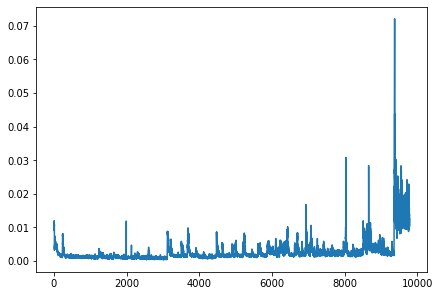

In [5]:
pupil_data = pupil_data[pupil_data['raw_pupil_area'].notna()]
values = pupil_data['raw_pupil_area']
time_points = pupil_data.index

#Create uniform set of data using interpolation
model = interpolate.interp1d(time_points, values)
time = np.arange(time_points[0], time_points[-1], 1/PF)
area = model(time)
plt.plot(time, area);

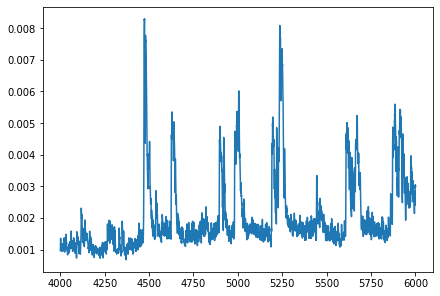

In [6]:
from scipy.ndimage import median_filter

stim_pupil_area = area[(time > 4000) & (time < 6000)] # approx time of spontaneous block
stim_time = time[(time > 4000) & (time < 6000)]
stim_pupil_filt = median_filter(stim_pupil_area, KERNEL_SIZE)
plt.plot(stim_time, stim_pupil_filt);

In [7]:
# settings for epoching (found based on experimentation in epoch_counts.ipynb)
ABOVE_THRESHOLD = 0.0000025
BELOW_THRESHOLD = -0.0000001
MIN_GAP = 0.05
ABOVE_MIN_DURATION = 0.5
BELOW_MIN_DURATION = 2

Signal Start: 4397.968316906174 s


Identified 4912 epochs
Joined 2205 / 4912 epochs
Joined 3837 / 4913 epochs
Dropped 2617 / 2707 epochs
Dropped 641 / 1076 epochs
Identified 3548 epochs
Joined 612 / 3548 epochs
Joined 2004 / 3548 epochs
Dropped 2863 / 2936 epochs
Dropped 1470 / 1544 epochs
Found 90 Above Epochs and 74 Below Epochs



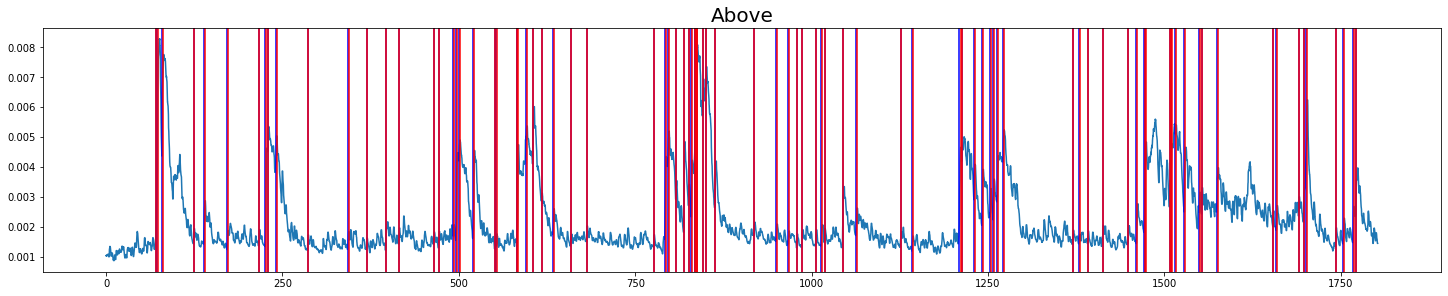

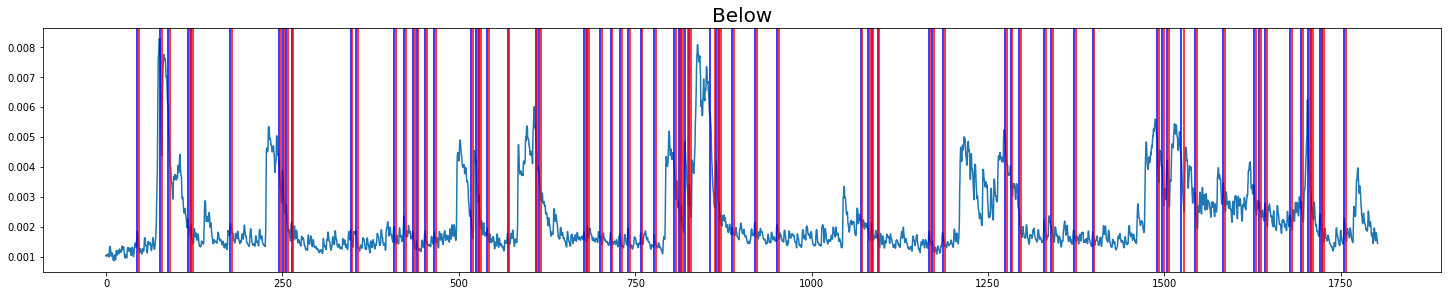

In [32]:
group = pd.read_pickle(f"G:/Shared drives/visual_encoding/data/behavior/pupil/spontaneous/pupil_area_{session_id}.pkl")
sig =  group.analogsignals[4]
print(f"Signal Start: {sig.t_start}\n\n")
area_deriv = np.diff(sig.magnitude.T[0])
above, _ = get_epoch_times(area_deriv, ABOVE_THRESHOLD, MIN_GAP, ABOVE_MIN_DURATION, PF)
_, below = get_epoch_times(area_deriv, BELOW_THRESHOLD, MIN_GAP, BELOW_MIN_DURATION, PF)

print(f'Found {len(above)} Above Epochs and {len(below)} Below Epochs\n')

plot_epochs(sig.magnitude.T[0], np.arange(0, len(sig.magnitude.T[0]))/PF, above)
plt.title("Above")

plot_epochs(sig.magnitude.T[0], np.arange(0, len(sig.magnitude.T[0]))/PF, below)
plt.title("Below");

In [11]:
# average length of above epochs (dilation)
np.mean(above[:,1] - above[:,0])

0.8295555555555593

In [12]:
# average length of below epochs (constriction)
np.mean(below[:,1] - below[:,0])

2.628648648648637

In [30]:
above_split = split_epochs(above, 0.7)
below_split = split_epochs(below, 2)

### Time-resolved FFT of LFP to extract parameters for shorter epochs

In [13]:
from allen_vc.allen_utils import find_probes_in_region, align_lfp

In [14]:
probe_id = find_probes_in_region(session, 'VISp')[0][0]
lfp = session.get_lfp(probe_id)

In [15]:
chan_ids = session.channels[(session.channels.probe_id==probe_id) & \
                    (session.channels.ecephys_structure_acronym=='VISp')].index.values

In [16]:
lfp_spont = lfp.sel(time=slice(4000, 6000)).sel(channel=slice(np.min(chan_ids), np.max(chan_ids)))
lfp_spont

<xarray.DataArray 'LFP' (time: 2499999, channel: 22)>
array([[ 3.51195e-04,  4.02285e-04,  3.41640e-04, ...,  2.53500e-05,
         9.55500e-06, -1.07250e-05],
       [ 3.55875e-04,  3.98970e-04,  3.25845e-04, ...,  2.24250e-05,
         7.99500e-06, -1.15050e-05],
       [ 3.61140e-04,  3.97995e-04,  3.41250e-04, ...,  2.04750e-05,
         7.99500e-06, -1.44300e-05],
       ...,
       [-2.76900e-05, -3.62700e-05, -5.03100e-05, ...,  2.73000e-06,
         0.00000e+00,  6.24000e-06],
       [-4.48500e-05, -4.95300e-05, -5.81100e-05, ..., -3.51000e-06,
         2.73000e-06,  0.00000e+00],
       [-4.17300e-05, -4.27050e-05, -6.76650e-05, ..., -5.46000e-06,
         3.31500e-06,  1.75500e-06]], dtype=float32)
Coordinates:
  * time     (time) float64 4e+03 4e+03 4e+03 4e+03 ... 6e+03 6e+03 6e+03 6e+03
  * channel  (channel) int64 850025318 850025326 ... 850025478 850025486

In [21]:
raw_lfp = lfp_spont.values
lfp_swapped = np.swapaxes(raw_lfp, 0 ,1)

In [23]:
# now we do time resolved fft!
import mne.time_frequency as mtf
from time import time as timer

In [24]:
# choose random time frame for experimentation
lfp_cropped = lfp_swapped[:,:10000]

In [25]:
t_start = timer()
psd = mtf.tfr_array_multitaper(np.array([lfp_cropped]),sfreq=1250,freqs=np.arange(1,30), output='power', verbose=True)
print(timer() - t_start)

1.4261701107025146


In [26]:
psd.shape # (n_epochs, n_chans, n_freqs, n_times)

(1, 22, 29, 10000)

In [27]:
import seaborn as sns

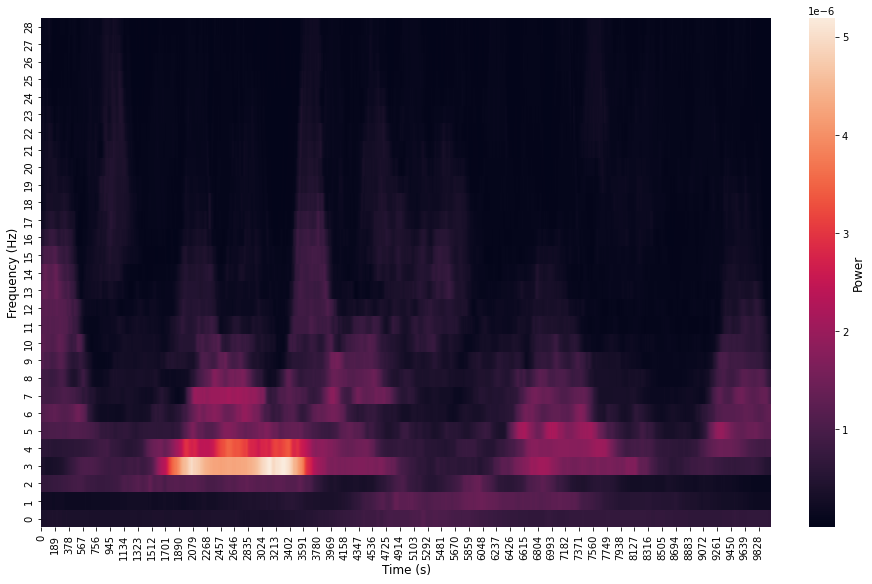

In [28]:
plt.figure(figsize=(12,8))
ax = sns.heatmap(psd[0,0,:,:], cbar_kws={'label': 'Power'});
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)');
ax.invert_yaxis()

In [ ]:
# now perform the analyses for every constriction/dilation epoch

In [59]:
# form arrays including each epoch

lfp_epochs = []

for epoch in (np.array(above_split) + float(sig.t_start)):
    
    lfp_epochs.append(lfp.sel(time=slice(epoch[0], 
                    epoch[1])).sel(channel=slice(np.min(chan_ids), 
                    np.max(chan_ids))).values)

above_lfp_epoched = np.swapaxes(np.array(lfp_epochs),1,2)

lfp_epochs = []

for epoch in (np.array(below_split) + float(sig.t_start)):
    
    lfp_epochs.append(lfp.sel(time=slice(epoch[0], 
                    epoch[1])).sel(channel=slice(np.min(chan_ids), 
                    np.max(chan_ids))).values)
    
below_lfp_epoched = np.swapaxes(np.array(lfp_epochs),1,2)

In [67]:
# 875 time points for above, 2500 for below (limits frequency range that can be observed)

above_lfp_epoched.shape, below_lfp_epoched.shape

((60, 22, 875), (77, 22, 2500))

In [84]:
# 
freq_range = np.arange(10,100)

dilation_mt = mtf.tfr_array_multitaper(above_lfp_epoched,sfreq=1250,freqs=freq_range, output='power', verbose=True)
constriction_mt = mtf.tfr_array_multitaper(below_lfp_epoched,sfreq=1250,freqs=freq_range, output='power', verbose=True)

In [85]:
dilation_mt.shape # epoch, channel, freqs, time points

(60, 22, 90, 875)

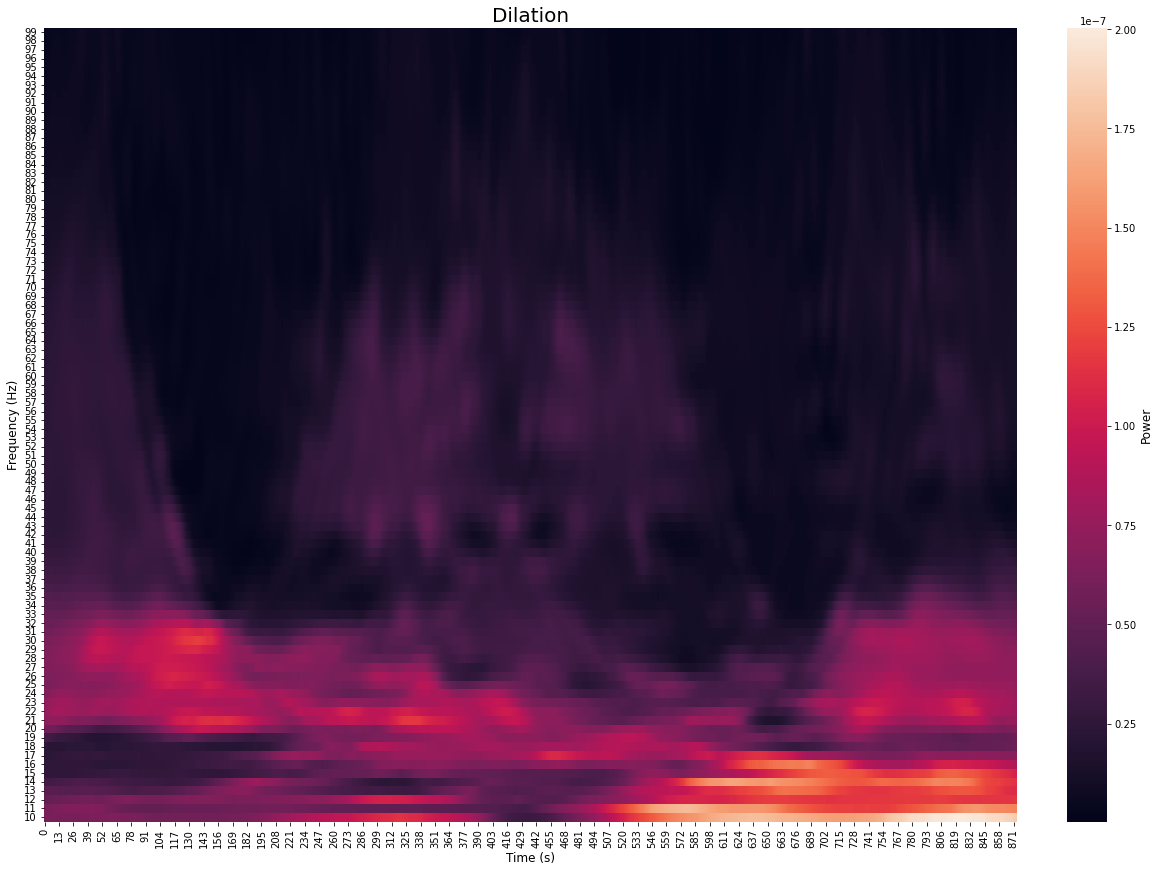

In [100]:
# look at an arbitrary dilation vs constriction epoch

plt.figure(figsize=(16,12))
ax = sns.heatmap(dilation_mt[20,0,:,:], cbar_kws={'label': 'Power'}, yticklabels=freq_range)
plt.title('Dilation')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
ax.invert_yaxis();

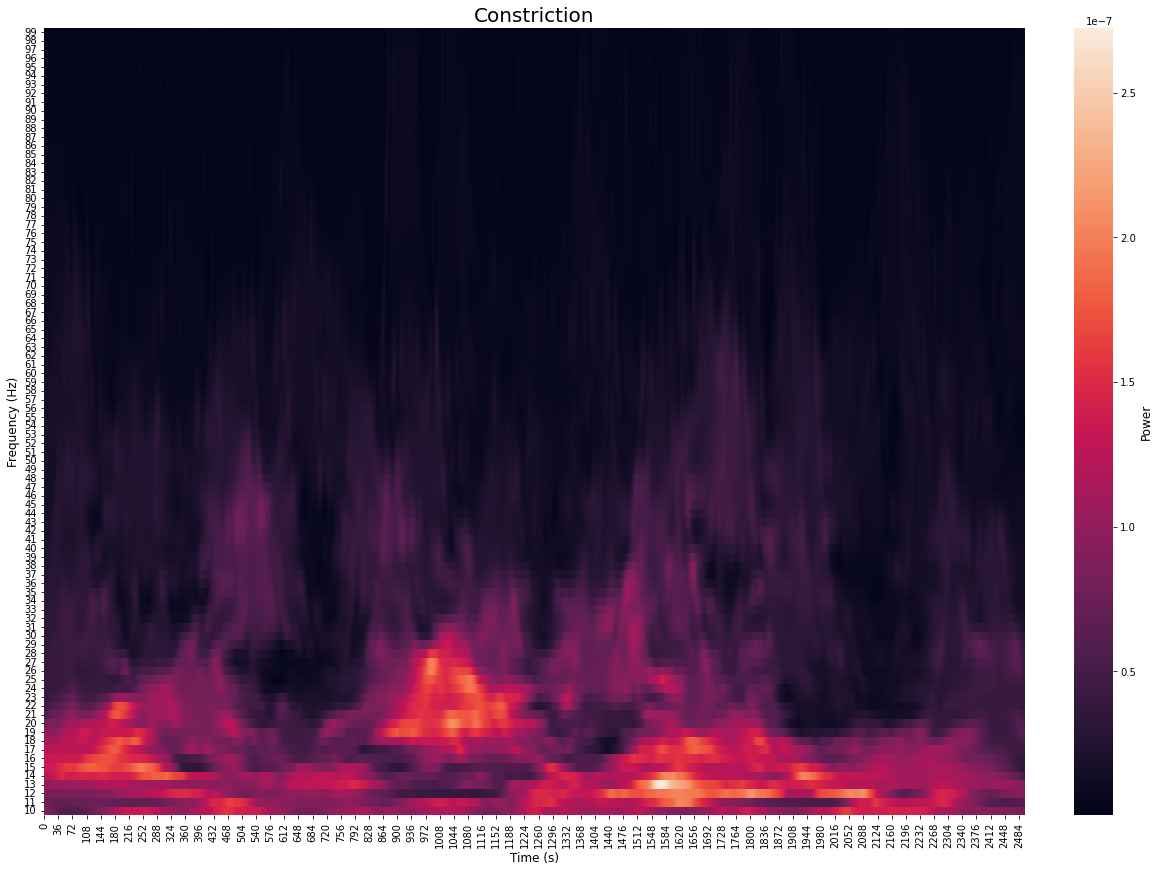

In [98]:
plt.figure(figsize=(16,12))
ax = sns.heatmap(constriction_mt[20,0,:,:], cbar_kws={'label': 'Power'}, yticklabels=freq_range)
plt.title('Constriction')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
ax.invert_yaxis();

# LFP Parameter Temporal Correlations

In [ ]:
# settings
REPO = 'C:/Users/User/visual_encoding'
DATA = 'G:/Shared drives/visual_encoding/data'

In [94]:
import pandas as pd
import numpy as np
import neo
import quantities as pq
import matplotlib.pyplot as plt
import sys
sys.path.append(f'{REPO}/allen_vc')

from plots import plot_linregress

print("Packages Imported")

Packages Imported


In [92]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# load in parameters and block
params = pd.read_csv(f'{DATA}/lfp_data/lfp_params/natural_movie_one_more_repeats/tfr/by_session/block_794812542.csv')
block = neo.io.NeoMatlabIO(f"{DATA}/blocks/lfp/natural_movie_one_more_repeats/block_794812542.mat").read_block()

In [5]:
block

Block with 60 segments
annotations: {'session_id': '794812542',
  'spike_brain_structures': 'VISp',
  'stimulus_name': 'natural_movie_one_more_repeats',
  'frame': 0,
  'lfp_brain_structure': 'VISp',
  'lfp_probe_ids': 810758781,
  'has_lfp_data': True}
# segments (N=60)
0: Segment with 3 analogsignals, 108 spiketrains
   annotations: {'stimulus_onset': 2290.8391181681786,
     'time_window': array([ 0, 30])}
   # analogsignals (N=3)
   0: AnalogSignal with 1 channels of length 1500; units cm/s; datatype float64 
      name: 'running_speed'
      sampling rate: 50.0 Hz
      time: 2290.84 s to 2320.84 s
   1: AnalogSignal with 1 channels of length 1500; units cm**2; datatype float64 
      name: 'pupil_area'
      sampling rate: 50.0 Hz
      time: 2290.84 s to 2320.84 s
   2: AnalogSignal with 37500 channels of length 25; units uV; datatype float32 
      name: 'lfp'
      annotations: {'data_type': 'lfp',
        'probe_id': 810758781,
        'brain_structure': 'VISp',
        'chan

In [10]:
# drop irrelevant columns
params.drop(['behavior', 'session'], axis=1, inplace=True)

In [13]:
# median across channels
params = params.groupby(['epoch_idx', 'window_idx']).median().drop(['chan_idx'], axis=1).reset_index()

In [15]:
params.head()

,epoch_idx,window_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,bw_1,cf_2,pw_2,bw_2,cf_3,pw_3,bw_3,error,r_squared
0,0,0,-4.377196,79.372278,2.444457,55.408522,1.203603,6.193719,88.276727,1.158714,5.549633,109.483642,1.158685,11.592293,121.952985,1.175975,13.753469,0.333627,0.822498
1,0,1,-4.203472,119.481438,2.478370,55.445389,1.172915,6.480384,84.570592,1.086712,10.301890,107.210722,1.177318,4.573228,121.735856,1.152062,13.417212,0.327045,0.825043
2,0,2,-3.989873,216.978614,2.611138,48.046803,1.177155,6.129258,76.629573,1.077389,4.925686,106.244265,1.137720,11.166907,126.817218,1.074398,11.294187,0.336847,0.820966
3,0,3,-4.021160,345.642160,2.509509,34.189422,1.107840,6.970991,72.133418,0.950321,17.597040,106.136011,1.292681,5.554802,143.339529,1.053403,13.337144,0.315007,0.819884
4,0,4,-3.588271,1257.933458,2.796115,9.390308,1.247754,3.203844,77.840832,1.003641,14.153530,107.475047,1.288889,5.731183,145.669792,1.088650,19.333503,0.295135,0.801731


In [16]:
# now let's add instantaneous spike rate data and pupil area data

In [86]:
# initialize arrays for storage
inst_spike_rate = np.array([])
avg_pupil_area = np.array([])

# use sliding window with same window size used for param calculation
window_size = 0.02*pq.s

# for each segment intialize storage
for seg in segs:
    seg_rates = np.empty((len(seg.spiketrains),0))
    seg_pupil_area = []
    i = seg.annotations['stimulus_onset']*pq.s
    
    # loop over sliding window
    while i <= seg.t_stop - window_size:
        
        # calculate average pupil area over window
        seg_pupil_area.append(np.mean(seg.analogsignals[1].time_slice(i, i+window_size)))
        
        # calculate spike train rates for each unit over window
        train_rates = []
        for train in seg.spiketrains:
            train_rates.append(np.sum(train.time_slice(i, i+window_size) > 0)/window_size)
        seg_rates = np.hstack((seg_rates, np.array([train_rates]).T))
        
        i += window_size
        
    # add segment data to total array
    avg_pupil_area = np.append(avg_pupil_area, seg_pupil_area)
    inst_spike_rate = np.append(inst_spike_rate, np.mean(seg_rates, axis=0))

In [87]:
avg_pupil_area.shape

(3000,)

In [88]:
inst_spike_rate.shape

(3000,)

In [89]:
params['inst_spike_rate'] = inst_spike_rate
params['avg_pupil_area'] = avg_pupil_area

params.head()

,epoch_idx,window_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,...,cf_2,pw_2,bw_2,cf_3,pw_3,bw_3,error,r_squared,inst_spike_rate,avg_pupil_area
0,0,0,-4.377196,79.372278,2.444457,55.408522,1.203603,6.193719,88.276727,1.158714,...,109.483642,1.158685,11.592293,121.952985,1.175975,13.753469,0.333627,0.822498,5.092593,0.001107
1,0,1,-4.203472,119.481438,2.478370,55.445389,1.172915,6.480384,84.570592,1.086712,...,107.210722,1.177318,4.573228,121.735856,1.152062,13.417212,0.327045,0.825043,5.092593,0.001106
2,0,2,-3.989873,216.978614,2.611138,48.046803,1.177155,6.129258,76.629573,1.077389,...,106.244265,1.137720,11.166907,126.817218,1.074398,11.294187,0.336847,0.820966,5.092593,0.001116
3,0,3,-4.021160,345.642160,2.509509,34.189422,1.107840,6.970991,72.133418,0.950321,...,106.136011,1.292681,5.554802,143.339529,1.053403,13.337144,0.315007,0.819884,6.018519,0.001125
4,0,4,-3.588271,1257.933458,2.796115,9.390308,1.247754,3.203844,77.840832,1.003641,...,107.475047,1.288889,5.731183,145.669792,1.088650,19.333503,0.295135,0.801731,6.481481,0.001134


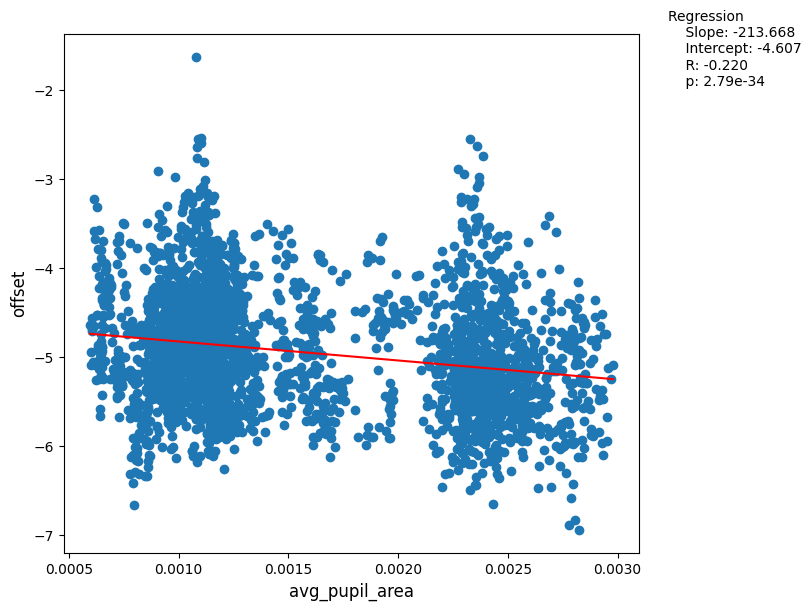

In [110]:
plot_linregress(params, 'avg_pupil_area', 'offset', show=True) 

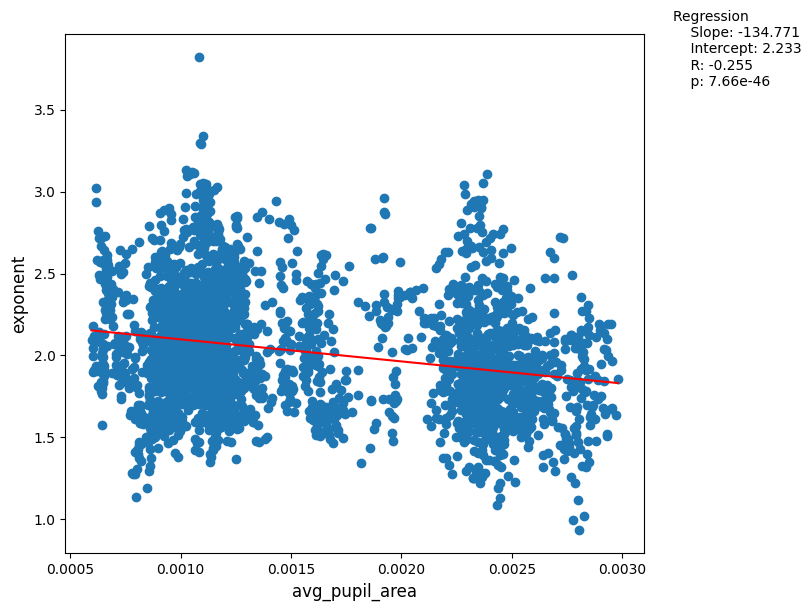

In [111]:
plot_linregress(params, 'avg_pupil_area', 'exponent', show=True) 

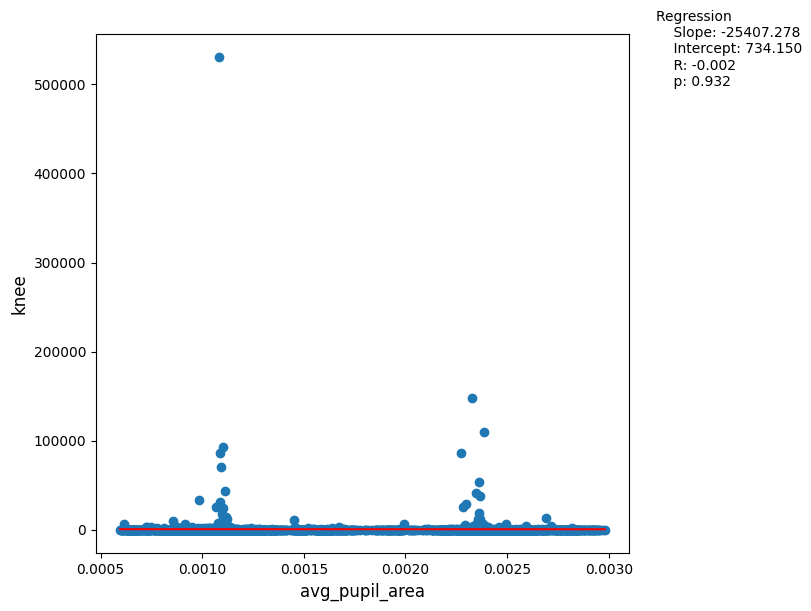

In [112]:
plot_linregress(params, 'avg_pupil_area', 'knee', show=True) 

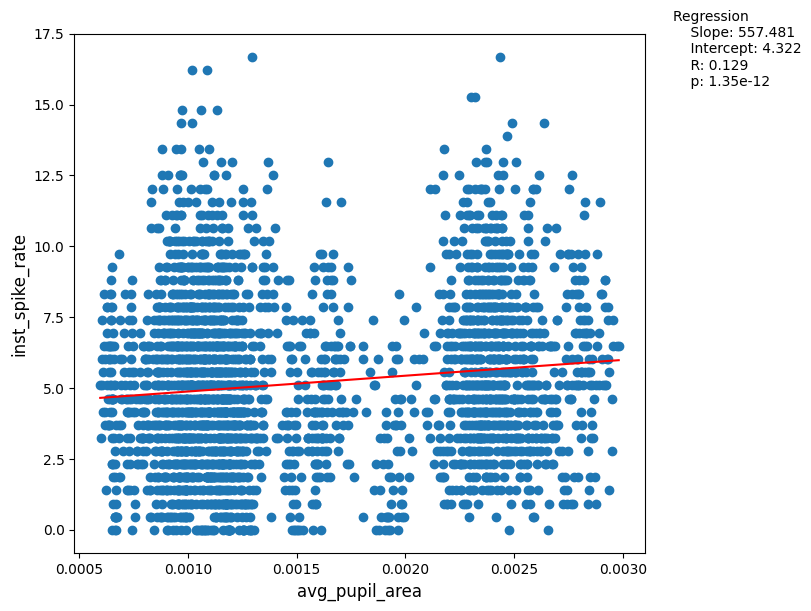

In [113]:
plot_linregress(params, 'avg_pupil_area', 'inst_spike_rate', show=True) 

In [105]:
# show first epoch only
first = params[params['epoch_idx']==1]

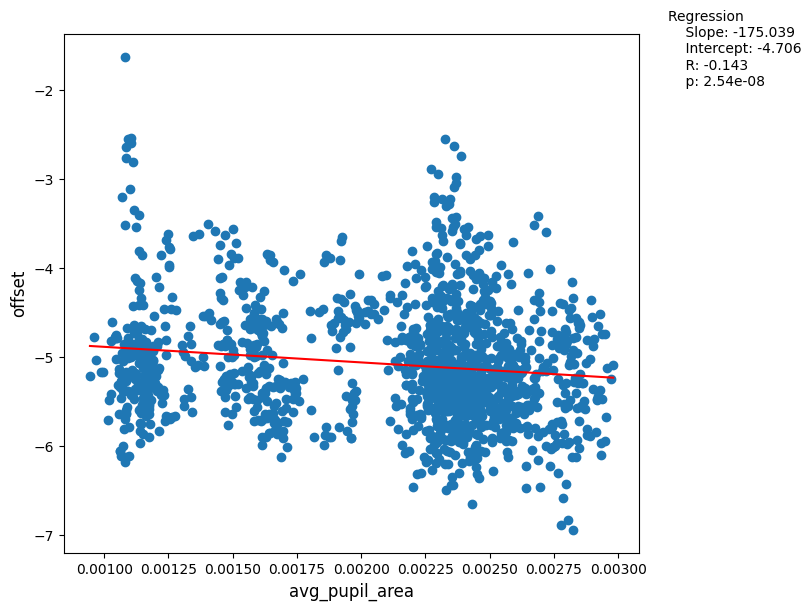

In [106]:
plot_linregress(first, 'avg_pupil_area', 'offset', show=True)    

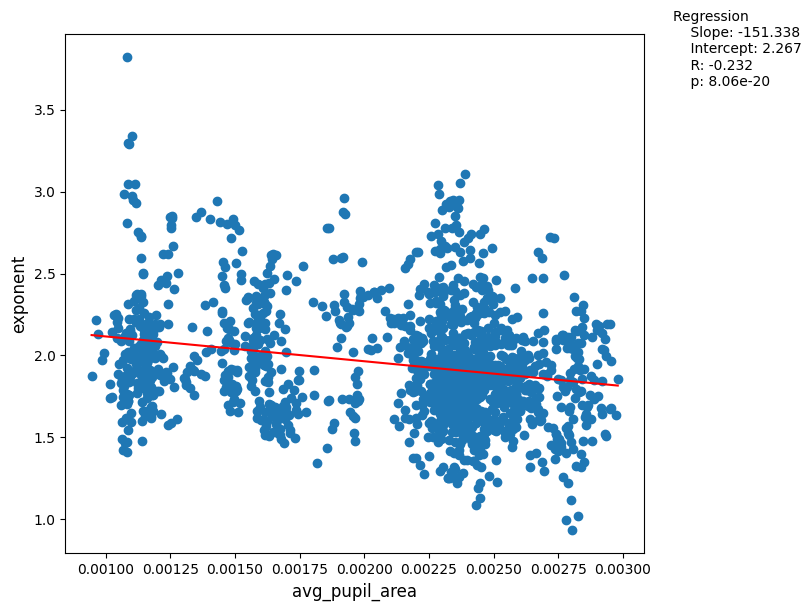

In [107]:
plot_linregress(first, 'avg_pupil_area', 'exponent', show=True)   

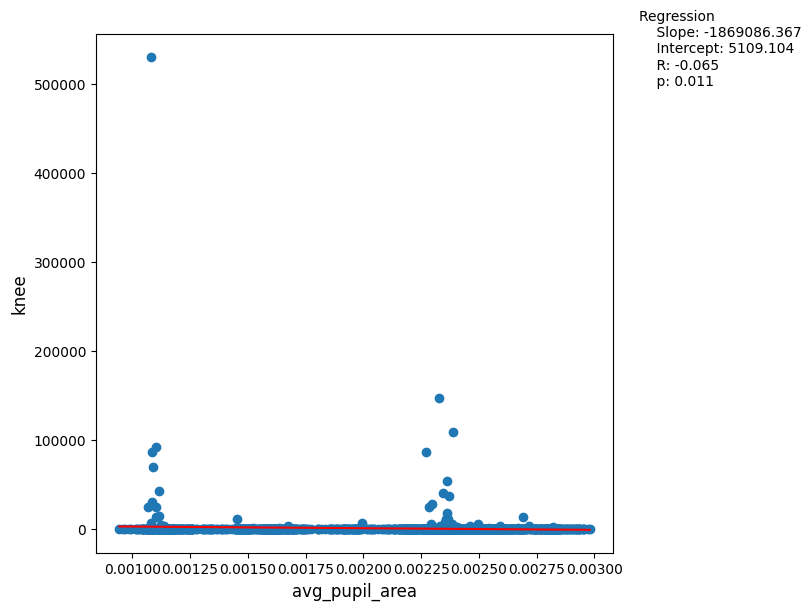

In [108]:
plot_linregress(first, 'avg_pupil_area', 'knee', show=True)   

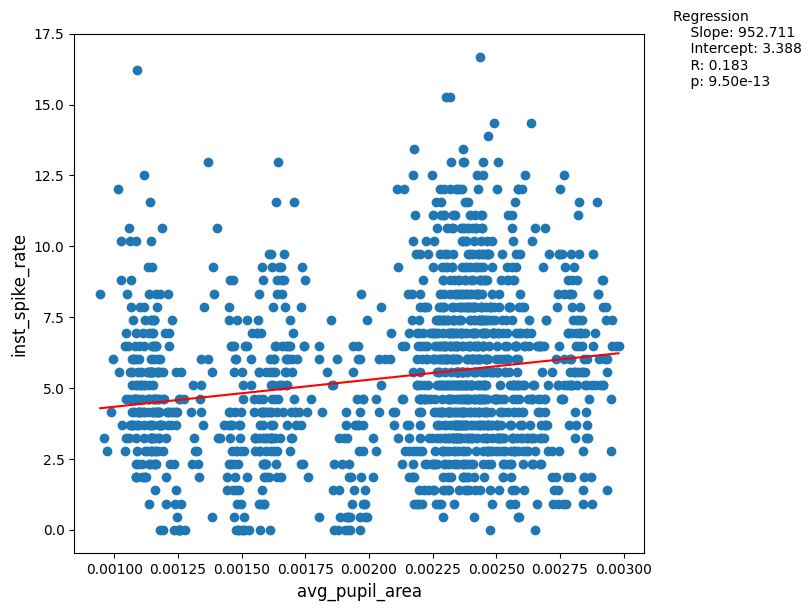

In [109]:
plot_linregress(first, 'avg_pupil_area', 'inst_spike_rate', show=True)   